## Model index posterior prior checks 

Generate several test data sets with different model priors. Predict for each sample in the data set the model index and check whether the relative frequencies of predicted models matches the prior probability. Because this is the ground truth case we can also check the ground truth. 

This check is not suited so well for our task. This is because it checks whether the relative frequencies of the predictions (model 0, model 1) match. However, the objective of the method is to predict the posterior probability and not the actually correct model. Thus, this test should be based on the assumption that there is enough data available so that the true posterior probabilities will be very close 0 or 1 for the respective model. 

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os 
import pickle
import sys 
import time
import tqdm

sys.path.append('../../')
from model_comparison.utils import *
from model_comparison.mdns import *
from model_comparison.models import PoissonModel, NegativeBinomialModel
%matplotlib inline

In [13]:
mpl_params = {'legend.fontsize': 18,
              'legend.frameon': False,
                      'axes.titlesize': 21,
                      'axes.labelsize': 19,
                      'xtick.labelsize': 15,
                      'ytick.labelsize': 15,
             'figure.figsize' : (18, 5)}

mpl.rcParams.update(mpl_params)

In [3]:
folder = '../data/'
fn = '201804052103__poisson_posterior_trained_N100000M100_k2.p'
time_stamp = fn[:fn.find('_')]

with open(os.path.join(folder, fn), 'rb') as f: 
    d = pickle.load(f)
    
# set the seed for generating new test data 
seed = 5
np.random.seed(seed)

In [4]:
d_model = d['d_model_post']
d_model.keys()

dict_keys(['seed', 'trainer', 'model_models', 'x', 'm', 'xtest', 'mtest', 'sx', 'sx_test', 'training_norm', 'param_poi', 'params_nb', 'theta1', 'theta2', 'theta3', 'k1', 'k2', 'k3', 'sample_size', 'n_samples', 'ppoi_exact'])

In [5]:
model = d_model['model_models']
x = d_model['x']
sx = d_model['sx']
xtest = d_model['xtest']
mtest = d_model['mtest']
ppoi_exact = d_model['ppoi_exact']
sx_test = d_model['sx_test']
sample_size = d_model['sample_size']

training_norm = d_model['training_norm']
k1, k2, k3 = d_model['k1'], d_model['k2'], d_model['k3']
theta1, theta2, theta3 = d_model['theta1'], d_model['theta2'], d_model['theta3']

# priors 
prior_lambda = scipy.stats.gamma(a=k1, scale=theta1)
prior_k = scipy.stats.gamma(a=k2, scale=theta2)
prior_theta = scipy.stats.gamma(a=k3, scale=theta3)

model_poisson = PoissonModel(sample_size=sample_size, seed=seed)
model_nb = NegativeBinomialModel(sample_size=sample_size, seed=seed)

In [6]:
ntest = 1000
model_priors_poisson = np.arange(0.1, 1., 0.1)
model_freq_poisson = np.zeros_like(model_priors_poisson)

for ii, model_prior_poisson in enumerate(model_priors_poisson): 

    # generate sampled indices from the prior 
    mi_test = (np.random.rand(ntest) > model_prior_poisson) * np.ones(ntest)
    n_nb = int(mi_test.sum())
    n_poi = ntest - n_nb

    # generate data 
    params_poi = prior_lambda.rvs(size=n_poi)
    params_nb = np.vstack((prior_k.rvs(size=n_nb), 
                           prior_theta.rvs(size=n_nb))).T

    data_poi = model_poisson.gen(params_poi)
    data_nb = model_nb.gen(params_nb)

    x_test = np.vstack((data_poi, data_nb))
    sx_test = calculate_stats_toy_examples(x_test)
    sx_test_zt, _ = normalize(sx_test, training_norm)

    # predict 
    posteriors = model.predict(sx_test_zt)
    # get prob of poisson 
    model_freq_poisson[ii] = posteriors[:, 0].sum() / ntest
    
    # get true posterior probs 
    
#     model_freq_poisson_true[ii] = 

In [7]:
folder = '../data/'
fn = '201804271008__modelposterior_comparison_exact_DE_SMC_ns10_ntest500.p'
time_stamp = fn[:fn.find('_')]

with open(os.path.join(folder, fn), 'rb') as f: 
    d_comparison = pickle.load(f)

In [8]:
x_test, sx_test, x, sx, ppoi_exact, ppoi_hat, ppoi_smc, ppoi_rej, prior_probs, meanpost_de, meanpost_smc= d_comparison.values()

In [9]:
err_de = np.abs(ppoi_hat - ppoi_exact)
err_smc = np.abs(ppoi_smc - ppoi_exact)
err_rej = np.abs(ppoi_rej - ppoi_exact)

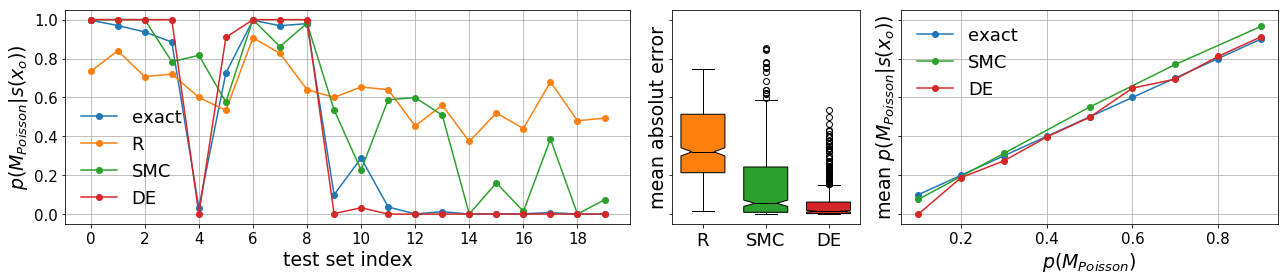

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(18, 4), sharey=True, gridspec_kw={'width_ratios': [3, 1, 2]})

idx = np.arange(sx_test.shape[0])
idx = idx[240:260]
nvis = idx.size

plt.sca(ax[0])
plt.plot(np.array(ppoi_exact)[idx], '-o', label='exact')
plt.plot(np.array(ppoi_rej)[idx], '-o', label='R')
plt.plot(np.array(ppoi_smc)[idx], '-o', label='SMC')
plt.plot(np.array(ppoi_hat)[idx], '-o', label='DE')
plt.ylabel(r'$p(M_{Poisson} | s(x_o))$')
plt.xlabel('test set index')
plt.xticks(np.arange(0, nvis, 2), np.arange(0, nvis, 2))
plt.grid()
plt.legend()

plt.sca(ax[1])
# plt.bar([0, 1, 2], [err_rej.mean(), err_smc.mean(), err_de.mean()], color=['C1', 'C2', 'C3'])

bp = plt.boxplot([err_rej, err_smc, err_de], notch=True, labels=['R', 'SMC', 'DE'], autorange=True, widths=.7, 
           patch_artist=True, medianprops={'color': 'k'});

for i, b in enumerate(bp['boxes']): 
    b.set(facecolor='C{}'.format(i+1))
plt.ylabel('mean absolut error')
plt.xticks([1, 2, 3], ['R', 'SMC', 'DE'], fontsize=18)

# plot prior checks 
plt.sca(ax[2])
plt.plot(prior_probs, prior_probs, '-o', label='exact')
plt.plot(np.arange(.1, 1., .2), meanpost_smc, '-o', label='SMC', color='C2')
plt.plot(prior_probs, meanpost_de, '-o', label='DE', color='C3')
plt.ylabel(r'mean $p(M_{Poisson} | s(x_o))$')
plt.xlabel(r'$p(M_{Poisson})$')
plt.grid()
plt.legend()
plt.tight_layout();

In [15]:
fn = time_stamp + 'prior_checks_k2_{}.png'.format(int(k2))
fig.savefig(os.path.join('../figures', fn), dpi=300)